In [18]:
import pathlib
import numpy as np
from scipy import stats, signal, fft
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from PIL import Image
import cv2

import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

## Data-Handling

In [34]:
DATA_DIR = 'data_map_cutouts/train4'
BATCH_SIZE = 128

In [35]:
# The actual Data handling

# Some transformations to apply to the dataset
to_tensor = transforms.ToTensor()                       # Convert it to a tensor
random_flips_v = transforms.RandomVerticalFlip(0.5)     # Flip it vertically with prob. 0.5
random_flips_h = transforms.RandomHorizontalFlip(0.5)   # Flip it horizontally with prob 0.5
to_grayscale = transforms.Grayscale(1)                  # Convert the image to a single channel image

# Composing the transformations
transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    # random_flips_h,
    # random_flips_v
])

# Creating the dataLoader
train_dir = pathlib.Path(DATA_DIR)                         # The directory 
train_data = datasets.ImageFolder(root      = train_dir,    # The dataset
                                  transform = transform)
dataLoader = DataLoader(dataset = train_data,         # The dataLoader (batches and shuffles the data)
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)

## Visualization

Shape of images from dataLoader: torch.Size([128, 1, 128, 128])


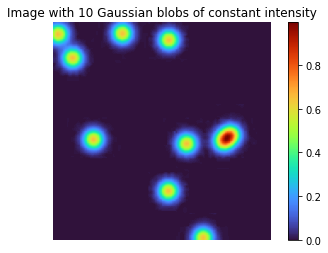

In [38]:
# Sampling from the dataset
images, labels = next(iter(dataLoader))
print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image

plt.imshow(images[0, 0, :, :].detach().cpu().numpy(), cmap='turbo')
plt.title('Image with 10 Gaussian blobs of constant intensity')
plt.axis('off')
plt.colorbar()
plt.show()

## Plotting the Intensity distribution

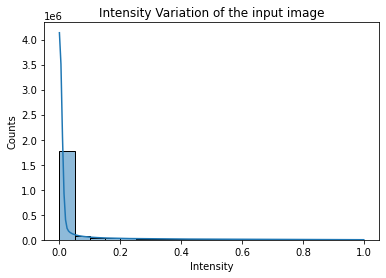

In [37]:
images, _ = next(iter(dataLoader))

images = images.detach().cpu().numpy()
images = np.reshape(images, (-1,))

# Use seaborn to plot the intensity distribution
sns.histplot(images, kde=True, binwidth=0.05)

# Set plot labels
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title("Intensity Variation of the input image")

# Show the plot
plt.show()

## Plotting the marginal distributions

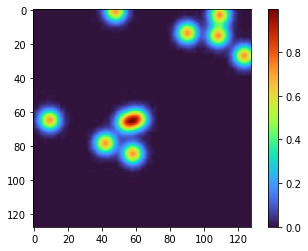

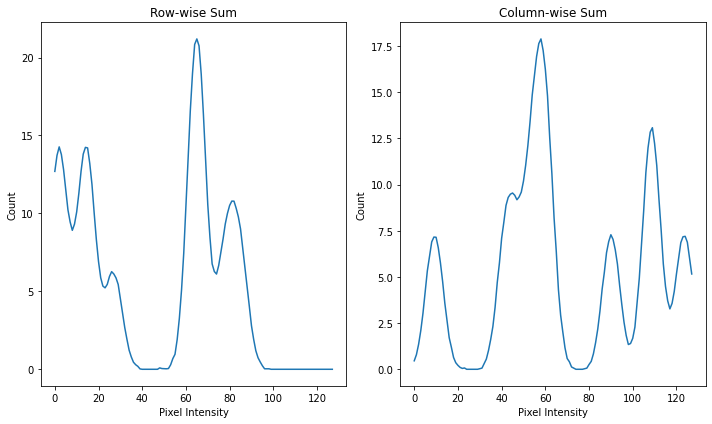

In [39]:
images, _ = next(iter(dataLoader))

image = images.detach().cpu().numpy()[0, 0, :, :]

# Calculate the row-wise and column-wise histograms
row_hist = np.sum(image, axis=1)
col_hist = np.sum(image, axis=0)

plt.imshow(image, cmap='turbo')
plt.colorbar()
# plt.axis('off')
plt.show()

# Create subplots for row and column histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot row-wise histogram
axes[0].plot(row_hist)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Count')
axes[0].set_title('Row-wise Sum')

# Plot column-wise histogram
axes[1].plot(col_hist)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Count')
axes[1].set_title('Column-wise Sum')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Counting the average number of peaks per image

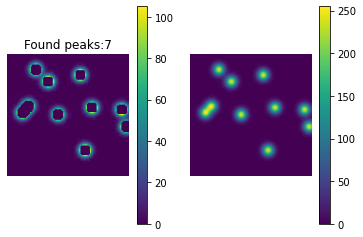

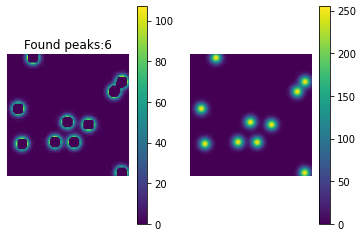

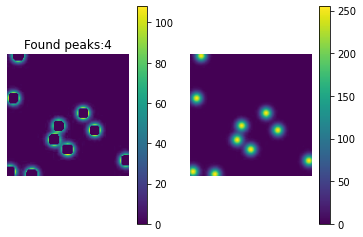

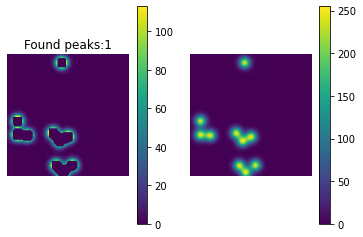

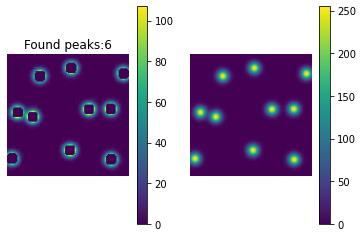

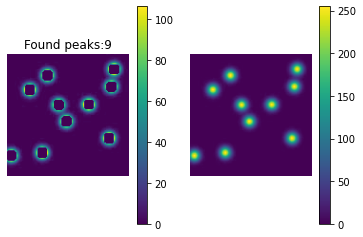

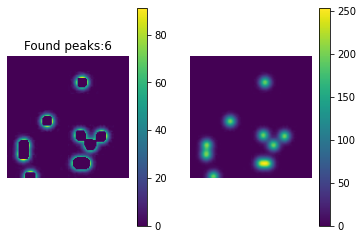

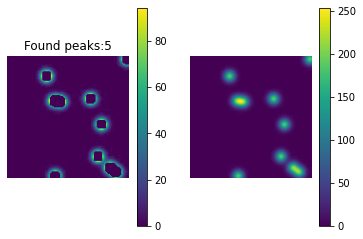

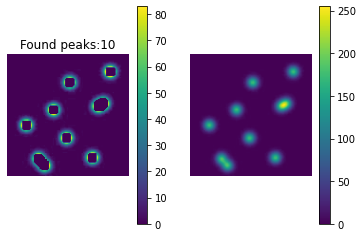

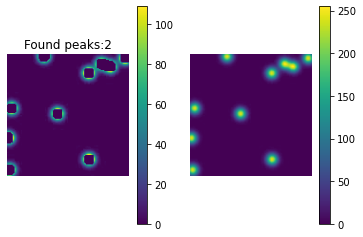

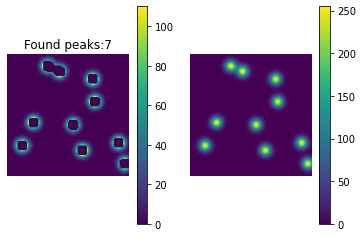

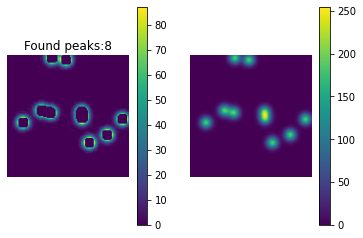

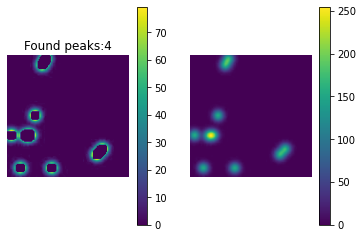

Found: 705


In [40]:
from skimage.feature import peak_local_max
images, _ = next(iter(dataLoader))
images = images.detach().cpu().numpy()

peak_area_list = []
for i in range(BATCH_SIZE):

    # Need to remove the streaks

    grey = cv2.convertScaleAbs(images[i, 0, :, :] * 255)

    _, binary = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Perform morphological operations to remove streaks
    kernel = np.ones((7,7), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Invert the binary image to create a mask for the streaks
    mask = 255 - opening
    # Apply the mask to the original image
    result = cv2.bitwise_and(grey, grey, mask=mask)

    
    
    # Define the minimum peak height and minimum distance between peaks
    min_peak_height = np.mean(images)
    min_peak_distance = 15

    # Find all the peaks in the image
    peaks = peak_local_max(image=images[i, 0, :, :], 
                           min_distance=min_peak_distance, 
                           threshold_abs=min_peak_height)
    for peak in peaks:
        min_x = peak[0] - 10
        min_y = peak[1] - 10
        max_x = peak[0] + 11
        max_y = peak[1] + 11
        
        peak_area_list.append(images[i, 0, min_x:max_x, min_y:max_y])

    if i % 10 == 0:
        plt.subplot(1,2,1)
        plt.imshow(result)
        plt.title("Found peaks:" + str(peaks.shape[0]))
        plt.axis('off')
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(grey)
        plt.axis('off')
        plt.colorbar()
        plt.show()


print("Found:", len(peak_area_list))

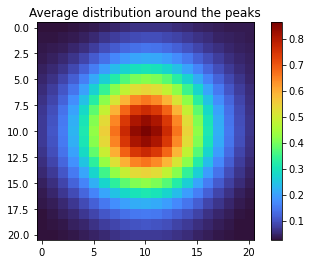

In [42]:
peak_avg = np.zeros((21, 21))
if len(peak_area_list) > 0: 
    for peak_area in peak_area_list:
        peak_avg += peak_area

    plt.imshow(peak_avg/len(peak_area_list), cmap='turbo')
else:
    plt.imshow(peak_avg)
plt.colorbar()
plt.title("Average distribution around the peaks")
plt.show()

In [43]:
# Define the Gaussian function
def gaussian(x, amplitude, variance):
    return amplitude * np.exp(-((x) ** 2) / (2 * variance))


In [44]:
def get_radial_dist(image = np.ones((21,21)), width=21, title='Intensity variation', best_fit=True):
    center = np.array([(width + 1) //2, (width + 1) // 2])
    # print("Center:", center)

    intensity_map = np.zeros(shape=(int(np.ceil(((width + 1 )// 2) * np.sqrt(2)))))
    counts = np.copy(intensity_map)

    for i in range(width):
        for j in range(width):
            pos = np.array([i, j])
            # print(pos)
            radius = int(np.linalg.norm(center - pos))
            # print(radius)
            intensity_map[radius] += image[i, j]
            counts[radius] += 1
    
    intensity_map = intensity_map / counts


    plt.plot(intensity_map)
    
    if best_fit:
        x = np.arange(intensity_map.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
        initial_guess = [1, 1.]  # Initial parameter guesses for the fit
        # try:
        optimized_parameters, _ = curve_fit(gaussian, x, intensity_map - np.min(intensity_map), p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
        amplitude_opt, var_opt = optimized_parameters
        print("----Best-fit parameters---")
        print("Amplitude:", amplitude_opt)
        # print("Mean:", mean_opt)
        print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
        y_fit = gaussian(x, amplitude_opt, var_opt) + np.min(intensity_map)
                
        plt.plot(y_fit)
        # except:
        #     print("ERROR: Best-fit Gaussian not found")
        # print(counts[0], counts[-1])
        plt.legend(['True intensity variation', 'Best-fit Gaussian'])
    plt.title(title)
    plt.show()

    return intensity_map

----Best-fit parameters---
Amplitude: 0.7704820092688822
Variance: 16.186544302909926


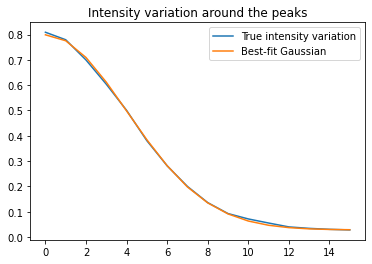

array([0.80900015, 0.77937701, 0.69945454, 0.60378363, 0.50049948,
       0.38068517, 0.28149833, 0.20001333, 0.13616982, 0.09293532,
       0.07171342, 0.05560181, 0.04024714, 0.03449636, 0.03070743,
       0.02837992])

In [46]:
get_radial_dist(peak_avg / len(peak_area_list), title='Intensity variation around the peaks')

In [47]:
print("Average no. of peaks per image:", len(peak_area_list)/BATCH_SIZE)

Average no. of peaks per image: 5.5078125


In [48]:
# Clean-up
del peak_area_list, peak_avg, peak, peak_area, peaks

## Image fft

(128, 1, 128, 128)


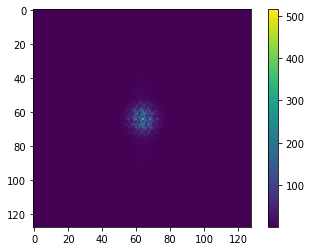

In [49]:
images, _ = next(iter(dataLoader))

images = images.detach().cpu().numpy()

# images = images - np.mean(images)

images_fft = fft.fftshift(fft.fft2(images))

images_fft_abs = np.abs(images_fft)

images_fft_abs[np.angle(images_fft) < -np.pi / 2] *= -1
images_fft_abs[np.angle(images_fft) > np.pi / 2] *= -1

print(images_fft.shape)
images_fft_abs = np.sum(images_fft_abs, axis=0)
plt.imshow((np.abs(images_fft[ 0, 0, :, :])))
plt.colorbar()
plt.show()

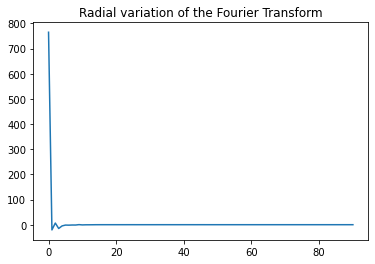

array([ 7.65075562e+02, -2.07446805e+01,  6.56518471e+00, -1.50783665e+01,
       -4.85165656e+00, -1.51815469e+00, -1.83280900e+00, -1.24048971e+00,
       -1.33932381e+00,  2.49525413e-01, -8.34464418e-01, -4.05576776e-01,
       -3.67810347e-01, -2.35244463e-01, -8.09643108e-02, -2.93619268e-02,
       -2.15835105e-02, -8.87955398e-03, -1.18355515e-02, -1.15505938e-02,
       -1.87554931e-02, -1.04752365e-02, -1.34190204e-02, -6.17666536e-03,
        3.78264047e-03,  4.34972463e-03, -1.34363212e-02,  2.03807718e-03,
       -1.20501468e-02, -6.54225716e-03, -5.46443873e-03, -9.24909654e-03,
        9.32327451e-04,  4.76822505e-03, -5.13135084e-03,  1.78752090e-02,
       -1.34674903e-03, -6.13704083e-03,  1.66958963e-03,  1.53192507e-03,
        4.19359275e-03,  4.82432028e-03,  1.19326265e-02, -4.90024014e-04,
       -3.05238147e-03,  3.62254032e-03,  2.47360479e-03, -3.24285817e-03,
        2.73001853e-03, -3.95261632e-03, -4.47320060e-03, -4.35913781e-03,
       -5.33360629e-03, -

In [50]:
get_radial_dist(image = images_fft_abs[0, :, :] / BATCH_SIZE, 
                width = 128, 
                best_fit = False, 
                title = 'Radial variation of the Fourier Transform')

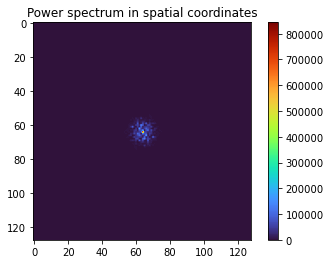

In [52]:
power_spectrum = np.abs(np.conj(images_fft) * images_fft)
plt.imshow((power_spectrum[10, 0, :, :]), cmap='turbo')
plt.colorbar()
plt.title("Power spectrum in spatial coordinates")
plt.show()